# Chap03-4. 영화 리뷰 분류: 이진 분류 문제
이 notebook에서는 리뷰 텍스트 기반으로 영화 리뷰를 긍정 혹은 부정으로 나누는 이진 분류를 IMDB 데이터셋을 이용해 보여주겠습니다.  
<br />

### IMDB 데이터셋
인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 50,000개로 이루어진 데이터셋입니다.  
이 데이터셋은 훈련 데이터 25,000개와 테스트 데이터 25,000개로 나뉘어 있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있습니다.  
<br />
한편 IMDB 데이터셋은 Keras에 포함되어 있습니다.  
이 데이터는 전처리되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있습니다. 여기서 각 숫자는 사전에 있는 고유한 단어를 나타냅니다.

In [1]:
# imdb 데이터셋 로드하기
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

`imdb.load_data()`를 통해서 데이터를 로드할 수 있으며, 파라미터인 `num_words`는 가장 많은 빈도로 존재하는 단어 10000개만 사용하겠다는 것을 나타냅니다.

이렇게 불러온 데이터셋은 전처리가 진행된 데이터이고, 출력해보면 다음과 같은 결과가 나옵니다.

In [2]:
print("1st train data: ", train_data[0])
print("1st train label: ", train_labels[0])

1st train data:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1st train label:  1


위와 같이 각 리뷰 데이터는 단어 인덱스의 리스트입니다.(단어가 인코딩 된 것) 그리고 라벨에서 0은 **부정**을, 1은 **긍정**을 나타냅니다.  
재미삼아 각 리뷰를 우리가 알아볼 수 있도록 원래의 텍스트로 돌려보도록 하겠습니다.  
자주 사용된 10000개의 단어만 사용했으므로 인덱스에 포함되지 않은 단어는 ?로 출력이 되도록 하겠습니다.

In [3]:
word_index = imdb.get_word_index()

def decode_review(review):
    reverse_word_index = dict(
        [(value, key) for (key, value) in word_index.items()])
    decode = ' '.join(
        [reverse_word_index.get(i - 3, '?') for i in review])
    return decode

In [4]:
decode_review(train_data[0])

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

위와 같이 영화에 대한 긍정적인 리뷰를 볼 수 있습니다.  
<br />
한편 keras에서 제공한 데이터셋과 같은 숫자 리스트는 바로 신경망에 넣어줄 수 없습니다.  
이 리스트를 텐서(벡터)로 변환하는 과정을 거쳐야 합니다.  
여기에서는 **one-hot encoding**을 사용하겠습니다.

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [6]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (25000, 10000)
x_test  (25000, 10000)


라벨 또한 벡터로 만들겠습니다.

In [7]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

y_train  (25000,)
y_test  (25000,)


그리고 훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서 훈련 데이터에서 10000개의 샘플을 추출해 검증 세트를 만들겠습니다.

In [8]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 신경망에 주입할 데이터는 모두 준비가 되었으니, 신경망 모델을 만들겠습니다.  
여기에서는 Sequential 클래스를 사용해 모델을 정의를 할 것인데, `relu` 활성화 함수를 사용한 Dense 층 두 개를 쌓고 마지막 층은 확률을 출력하기 위해 `sigmoid` 활성화 함수를 사용하겠습니다.  
![neural networks structure](./images/nn-2.png)

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

마지막으로 손실함수와 옵티마이저를 선택하면 학습 할 준비가 끝납니다.  
이 문제는 이진 분류 문제이고 신경망의 출력이 확률이기 때문에, `binary_crossentropy`손실이 적합합니다.(`mean_squared_error`도 사용가능합니다.)  
또한 옵티마이저는 SGD 종류 중 하나인 `RMSProp`를 사용하겠습니다.  
`metrics`에는 평가 할 지표를 넣으면 되는데 이진 분류에서의 정확도를 나타내는 `binary_accuracy`를 사용하겠습니다. ([[링크](https://keras.io/metrics/#available-metrics)] 참조)  
케라스에는 `rmsprop`, `binary_crossentropy`, `accuracy`가 이미 포함되어 있지만 여기에서는 모듈을 불러와서 사용하겠습니다.

In [10]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

이제 컴파일이 끝나면 모델을 학습시키면 됩니다.  
512개의 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킵니다.  
위에서 만든 검증 세트를 사용해서 훈련하는 동안의 정확도를 측정할 수 있습니다.

In [11]:
history = model.fit(partial_x_train,
                  partial_y_train,
                  epochs=20,
                  batch_size=512,
                  validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 143us/step - loss: 0.4974 - binary_accuracy: 0.7951 - val_loss: 0.3795 - val_binary_accuracy: 0.8655
Epoch 2/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.2939 - binary_accuracy: 0.9038 - val_loss: 0.3006 - val_binary_accuracy: 0.8870
Epoch 3/20
15000/15000 [==============================] - 1s 89us/step - loss: 0.2146 - binary_accuracy: 0.9297 - val_loss: 0.2771 - val_binary_accuracy: 0.8904
Epoch 4/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.1708 - binary_accuracy: 0.9437 - val_loss: 0.2768 - val_binary_accuracy: 0.8866
Epoch 5/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.1357 - binary_accuracy: 0.9563 - val_loss: 0.2823 - val_binary_accuracy: 0.8878
Epoch 6/20
15000/15000 [==============================] - 1s 89us/step - loss: 0.1144 - binary_accuracy: 0.9631 - val_loss: 0.3021 - val_binary_

`model.fit()` 메서드는 `History` 객체를 반환합니다. 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있습니다.

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

matplotlib을 통해서 훈련과 검증 손실, 훈련과 검증 정확도를 그려보도록 하겠습니다

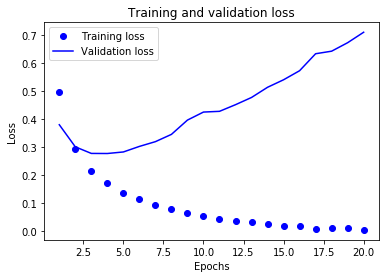

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

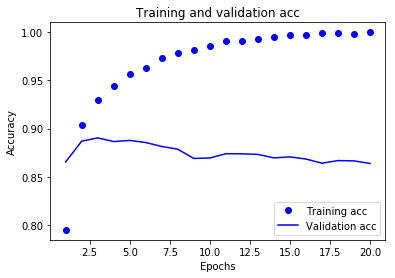

In [14]:
plt.clf()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

여기에서 보면 기대한 대로 학습 손실은 감소하고 학습 정확도는 증가함을 볼 수 있는데, 검증 세트에 대한 손실과 정확도는 그렇지 않다는 것을 볼 수 있습니다.  
이는 우리의 모델이 훈련 데이터에 **과적합** 되었다는 의미이고, 이런 모델은 새로운 데이터에 대해서 좋은 예측을 할 수 없습니다.  
그렇기 때문에 모델이 과적합 되기 전인 네 번째 에포크 동안만 훈련을 처음부터 다시 시켜 이번에는 테스트 데이터로 예측 및 평가를 하겠습니다.

In [15]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 62us/step - loss: 0.4577 - binary_accuracy: 0.8222
Epoch 2/4
25000/25000 [==============================] - 1s 52us/step - loss: 0.2631 - binary_accuracy: 0.9073
Epoch 3/4
25000/25000 [==============================] - 1s 59us/step - loss: 0.2026 - binary_accuracy: 0.9271
Epoch 4/4
25000/25000 [==============================] - 3s 107us/step


In [16]:
results

[0.2971209902191162, 0.88256]

이와 같이 간단한 모델을 사용해 87%의 정확도를 달성했습니다.  
<br />
또한 `predict`메서드를 이용하면 훈련시킨 모델을 실전 환경에서도 사용할 수 있어 어떤 리뷰가 긍정일 확률을 예측할 수 있습니다.

In [17]:
model.predict(x_test)

array([[0.19154617],
       [0.9998211 ],
       [0.9308494 ],
       ...,
       [0.18322498],
       [0.1177181 ],
       [0.719048  ]], dtype=float32)

### 요약
* 원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요합니다.
* `relu` 활성화 함수와 함께 Dense 층을 쌓은 네트워크는 여러 종류의 문제에 적용할 수 있습니다.
* 이진 분류 분제에서 네트워크는 하나의 유닛과 `sigmoid` 활성화 함수를 가진 Dense 층으로 끝나야 합니다. 이 신경망의 출력은 0과 1사이의 스칼라 값입니다.
* 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 `binary_crossentropy`입니다.
* `rmsprop` 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택입니다.

## +) TensorFlow를 이용해 구현해보기

In [18]:
import tensorflow as tf
from sklearn.utils import shuffle

# label의 데이터 사이즈 변경(축 추가) 및 데이터 셔플
y_train_ = y_train[:, np.newaxis]
y_test_ = y_test[:, np.newaxis]
x_train_, y_train_ = shuffle(x_train, y_train_)
x_test_, y_test_ = shuffle(x_test, y_test_)

# Placeholder 선언(feed할 데이터와 라벨)
inputs = tf.placeholder(tf.float32, [None, 10000])
labels = tf.placeholder(tf.float32, [None, 1])

# 모델 정의
# layer 1 (10000, 16) - activation: relu
W1 = tf.Variable(tf.random_normal([10000, 16]))
b1 = tf.Variable(tf.random_normal([16]))
y1 = tf.nn.relu(tf.matmul(inputs, W1) + b1)

# layer 2 (16, 16) - activation: relu
W2 = tf.Variable(tf.random_normal([16, 16]))
b2 = tf.Variable(tf.random_normal([16]))
y2 = tf.nn.relu(tf.matmul(y1, W2) + b2)

# layer 3 (16, 1) - activation: sigmoid
W3 = tf.Variable(tf.random_normal([16, 1]))
b3 = tf.Variable(tf.random_normal([1]))

logits = tf.matmul(y2, W3) + b3

# 손실 함수는 cross_entropy, 옵티마이저는 rmsprop 사용 (learning rate는 0.04)
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
train_step = tf.train.RMSPropOptimizer(0.04).minimize(cross_entropy)

predicted = tf.cast(tf.nn.sigmoid(logits) > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))

# 학습 및 평가
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 배치 사이즈와 에포크 지정
    batch_size = 512
    training_epochs = 7

    for epoch in range(training_epochs):
        batch_count = int(x_train_.shape[0] / batch_size)
        for i in range(batch_count):
            batch_xs = x_train_[i * batch_size : min((i + 1) * batch_size, x_train_.shape[0])]
            batch_ys = y_train_[i * batch_size : min((i + 1) * batch_size, x_train_.shape[0])]

            sess.run(train_step, feed_dict={inputs: batch_xs, labels: batch_ys})

        loss, acc = sess.run([cross_entropy, accuracy], feed_dict={inputs: batch_xs, labels: batch_ys})
        print('Epoch ' + str(epoch + 1) + '/' + str(training_epochs))
        print('loss: {:.4f} | accuracy: {:.4f}'.format(loss, acc))

    test_loss, test_acc = sess.run([cross_entropy, accuracy], feed_dict={inputs: x_test_, labels: y_test_})
    print('\ntest loss: {:.4f} | test accuracy: {:.4f}'.format(test_loss, test_acc))

Epoch 1/7
loss: 2.5925 | accuracy: 0.5234
Epoch 2/7
loss: 0.7361 | accuracy: 0.5566
Epoch 3/7
loss: 0.6008 | accuracy: 0.6699
Epoch 4/7
loss: 0.3553 | accuracy: 0.8496
Epoch 5/7
loss: 0.2147 | accuracy: 0.9160
Epoch 6/7
loss: 0.1533 | accuracy: 0.9570
Epoch 7/7
loss: 0.1240 | accuracy: 0.9570

test loss: 0.4149 | test accuracy: 0.8549
